In [0]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Vision System Project CA1 and CA2B/CA1-SSD/')
!ls
!pip install imgaug

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
 Codes			      'Pixel Representation for SSD.gsheet'
 data			       predefined_classes.txt
'Final Report.docx'	       pretrain_ssd224.h5
'Final Report _ donal.docx'   'Reading Materials.gdoc'
 keras_ssd_pretrained_224.py   Report
 MobileNets.pdf		       Supermarket_Dataset_Vidur
 MobileNetv2.pdf	       train_ssd.ipynb
 old_weights


In [0]:
import numpy as np
from array import array
import cv2
from math import ceil
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
import glob

from keras_ssd_pretrained_224 import build_model
from keras_ssd_pretrained_224 import SSDLoss
from keras_ssd_pretrained_224 import datagen
from keras_ssd_pretrained_224 import SSDInputEncoder
from keras_ssd_pretrained_224 import decode_detections
from keras_ssd_pretrained_224 import xml_to_csv
from keras_ssd_pretrained_224 import read_csv
from keras_ssd_pretrained_224 import image_augmentation

# 1. Building Model

In [0]:
# Load pre-trained weights
loadweights = True
weightsfile = "pretrain_ssd224.h5"

# Model Parameters
aspect_ratio = [1, 2, 3, 0.5, 0.33]
n_classes = 2
img_height = 224
img_width = 224
img_channels = 3
min_scale = 0.1
max_scale = 0.9
normalize_coords = False

In [0]:
# Build Model
model = build_model((img_height,img_width,img_channels),
                n_classes,
                l2_reg=0.0,
                min_scale=min_scale,
                max_scale=max_scale,
                aspect_ratios=aspect_ratio,
                normalize_coords=normalize_coords)

if loadweights:
    model.load_weights(weightsfile)
    print("weights Loaded")


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model = build_model((img_height,img_width,img_channels),
                n_classes,
                l2_reg=0.0,
                min_scale=min_scale,
                max_scale=max_scale,
                aspect_ratios=aspect_ratio,
                normalize_coords=normalize_coords)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
9412608/9406464 [==============================] - 2s 0us/step
weights Loaded

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (No

# 2. Data Generator
 In this section we create two data generators, one each for training and validation.
 The data generator function(*data_generator*) accepts image and xml directory, along with some image augmentation parameters. 

In [0]:
data_dir = 'data/'
train_image_dir = data_dir+'img_train/'
val_image_dir = data_dir+'img_val/'
batch_size = 20

# Featue Map shape of each predictor layer
predictor_sizes = [model.get_layer('classes1').output_shape[1:3],
                   model.get_layer('classes2').output_shape[1:3],
                   model.get_layer('classes3').output_shape[1:3],
                   model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3]]


# Ground Truth Label encoder
label_encoder = SSDInputEncoder(img_height,
                                img_width,
                                n_classes,
                                predictor_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                aspect_ratios=aspect_ratio,
                                pos_iou_threshold=0.5,
                                neg_iou_limit=0.3,
                                normalize_coords=normalize_coords,
                                background_id=0)
train_dataset, n_train_imgs = datagen.data_generator(img_dir = train_image_dir, xml_dir = train_image_dir, batch_size=batch_size, steps_per_epoch=None, img_sz=224, label_encoder=label_encoder,
                                                   translate=0, rotate=0, scale=1, shear=0, hor_flip=True, ver_flip=False)

val_dataset, n_val_imgs = datagen.data_generator(img_dir = val_image_dir, xml_dir = val_image_dir, batch_size=batch_size, steps_per_epoch=None, img_sz=224, label_encoder=label_encoder,
                       translate=0, rotate=0, scale=1, shear=0, hor_flip=False, ver_flip=False)

print("train images : ", n_train_imgs)
print("validation images : ", n_val_imgs)

Successfully created labels.csv file at xml directory.
Successfully created labels.csv file at xml directory.
train images :  246
validation images :  60


# 3 Learning Rate Schedule

In [0]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 80:
        return 0.0005
    elif epoch < 100:
        return 0.0005
    elif epoch < 200:
        return 0.0004
    elif epoch < 300:
        return 0.0004
    elif epoch < 500:
        return 0.0003
    elif epoch < 600:
        return 0.0002
    elif epoch < 800:
        return 0.0001
    else:
        return 0.00005

      
      
learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

# 4 Model Checkpoints

In [0]:

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='pretrain_ssd224.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)


csv_logger = CSVLogger(filename='pretrain_ssd224+12_training_log.csv',
                       separator=',',
                       append=True)


callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler]







# 5 Fit Generator

In [0]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch = 0
final_epoch = 1000
train_steps_per_epoch = ceil(train_imgs/batch_size)
val_steps_per_epoch = ceil(val_imgs/batch_size)
val_dataset_size = 10

history = model.fit_generator(generator=train_dataset,
                              validation_data=val_dataset,
                              validation_steps=val_steps_per_epoch,
                              steps_per_epoch=train_steps_per_epoch,
                              callbacks = callbacks,
                              epochs=final_epoch)

#6 Prediction

In [0]:
# Inference Parameters
confidence_thresh=0.2,
iou_threshold=0.5

test_image_dir = data_dir + 'img_test/'
test_imgs = glob.glob(test_image_dir+"*.jpg")

csv_path = xml_to_csv(test_image_dir)
data_csv = read_csv(test_image_dir, "labels.csv")

Successfully created labels.csv file at xml directory.


## 6.1 Test Set Evaluation

IMG_20191025_145620.jpg
IMG_20191025_145623.jpg
IMG_20191025_145632.jpg
IMG_20191025_145641.jpg
IMG_20191025_151013.jpg
IMG_20191025_151016.jpg
IMG_20191025_151021.jpg
IMG_20191025_151307.jpg
IMG_20191025_151310.jpg
IMG_20191025_151314.jpg
IMG_20191025_151317.jpg
IMG_20191025_151319.jpg
IMG_20191025_151515.jpg
IMG_20191025_151535.jpg
IMG_20191025_151544.jpg
The total loss for the entire test set is 0.00


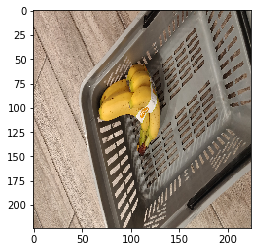

In [0]:

# %% Block 6a: Predictions on Test Image (With labels)

y_pred = []
test_shape = []
prediction = []
total_loss = 0

for i in range(len(test_imgs)):
    # for i in range(2):

    # Getting Ground Truth Y Label
    filename = test_imgs[i].split('/')[-1]
    image_aug, y_truth = image_augmentation(filename, img_dir=test_image_dir, data_csv=data_csv)
    y_truth = y_truth.reshape(1, y_truth.shape[0], y_truth.shape[1])
    y_truth = label_encoder(y_truth)

    # Getting Predicted Y
    img = cv2.imread(test_imgs[i])
    img_shape = [img.shape[0], img.shape[1]]
    test_shape.append(img_shape)

    img = cv2.resize(img, (224, 224))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    Current_pred = y_truth
    prediction.append(Current_pred)
    y_pred_decoded = decode_detections(Current_pred,
                                       confidence_thresh=confidence_thresh,
                                       iou_threshold=iou_threshold,
                                       top_k=200)
    y_pred.append(y_pred_decoded)

    # Computing Loss
    total_loss = tf.add(ssd_loss.compute_loss(y_truth, Current_pred), total_loss)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print('The total loss for the entire test set is %.2f' % total_loss.eval())


# Converting Prediction to actual Image Size
for i in range(len(y_pred)):# for each image
    for j in range(len(y_pred[i][0])): # for each bounding box
        # x axis with img rows
        y_pred[i][0][j][2] = y_pred[i][0][j][2] / img_width * test_shape[i][1]
        y_pred[i][0][j][4] = y_pred[i][0][j][4] / img_width * test_shape[i][1]

        # y axis with img cols
        y_pred[i][0][j][3] = y_pred[i][0][j][3] / img_height * test_shape[i][0]
        y_pred[i][0][j][5] = y_pred[i][0][j][5] / img_height * test_shape[i][0]



# 6.2 Plotting Prediction

In [0]:

colors = plt.cm.hsv(np.linspace(0, 1, n_classes + 1)).tolist()  # colors for the bounding boxes
classes = ['background','Banana', 'Apple']
select_idx = 0  # select the test image to display

img = cv2.imread(test_imgs[select_idx])
plt.figure(figsize=(20, 12))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

current_axis = plt.gca()

print('Selected Image shape:', img.shape)

for box in y_pred[select_idx][0]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    print('coordinates when plotting',xmin, ymin, xmax, ymax)
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, color=color, fill=False, linewidth=2))
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor': color, 'alpha': 1.0})

plt.show()
print('end')


# Encoder Decoder Test

Successfully created labels.csv file at xml directory.
IMG_20191025_145620.jpg
y_truth returned from image_augmentation [[[  1.         108.597229    72.6764679  163.722229   183.44117737]]]
y_truth returned from decode_detections [array([[  1.        ,   1.        , 108.597229  ,  72.6764679 ,
        163.722229  , 183.44117737]])]
IMG_20191025_145623.jpg
y_truth returned from image_augmentation [[[  1.          97.70832825  35.9264679  134.75       159.97059631]]]
y_truth returned from decode_detections [array([[  1.        ,   1.        ,  97.70832825,  35.9264679 ,
        134.75      , 159.97059631]])]
IMG_20191025_145632.jpg
y_truth returned from image_augmentation [[[  1.         105.3888855   60.4264679  150.74304199 181.48529053]]]
y_truth returned from decode_detections [array([[  1.        ,   1.        , 105.3888855 ,  60.4264679 ,
        150.74304199, 181.48529053]])]
IMG_20191025_145641.jpg
y_truth returned from image_augmentation [[[  1.          95.66667175  54.0441169

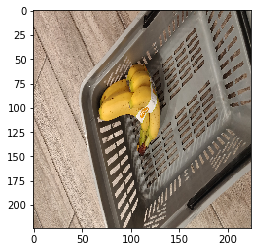

In [0]:

# %% Block 6a: Predictions on Test Image (With labels)

confidence_thresh = 0.2,
iou_threshold = 0.5

test_image_dir = 'data/img_test/'
test_imgs = glob.glob(test_image_dir+"*.jpg")

csv_path = xml_to_csv(test_image_dir)
data_csv = read_csv(test_image_dir, "labels.csv")

y_pred = []
test_shape = []
prediction = []
total_loss = 0

for i in range(len(test_imgs)):
    # for i in range(2):

    # Getting Ground Truth Y Label
    filename = test_imgs[i].split('/')[-1]
    print(filename)
    image_aug, y_truth = image_augmentation(filename, img_dir=test_image_dir, data_csv=data_csv)
    y_truth = y_truth.reshape(1, y_truth.shape[0], y_truth.shape[1])
    print('y_truth returned from image_augmentation',y_truth)
    y_truth = label_encoder(y_truth)

    # Getting Predicted Y
    img = cv2.imread(test_imgs[i])
    img_shape = [img.shape[0], img.shape[1]]
    test_shape.append(img_shape)

    img = cv2.resize(img, (224, 224))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    Current_pred = y_truth
    prediction.append(Current_pred)
    y_pred_decoded = decode_detections(Current_pred,
                                       confidence_thresh=confidence_thresh,
                                       iou_threshold=iou_threshold,
                                       top_k=200)
    print('y_truth returned from decode_detections', y_pred_decoded)
    y_pred.append(y_pred_decoded)

    # Computing Loss
    total_loss = tf.add(ssd_loss.compute_loss(y_truth, Current_pred), total_loss)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    print('The total loss for the entire test set is %.2f' % total_loss.eval())


# Converting Prediction to actual Image Size
for i in range(len(y_pred)):# for each image
    for j in range(len(y_pred[i][0])): # for each bounding box
        # x axis with img rows
        y_pred[i][0][j][2] = y_pred[i][0][j][2] / img_width * test_shape[i][1]
        y_pred[i][0][j][4] = y_pred[i][0][j][4] / img_width * test_shape[i][1]

        # y axis with img cols
        y_pred[i][0][j][3] = y_pred[i][0][j][3] / img_height * test_shape[i][0]
        y_pred[i][0][j][5] = y_pred[i][0][j][5] / img_height * test_shape[i][0]
        print('y_truth after resizing',y_pred[i][0][j])



Current Selected Image shape: (2176, 4608, 3)
coordinates when plotting 2234.0001395089284 705.9999738420759 3368.0001395089284 1782.000008719308


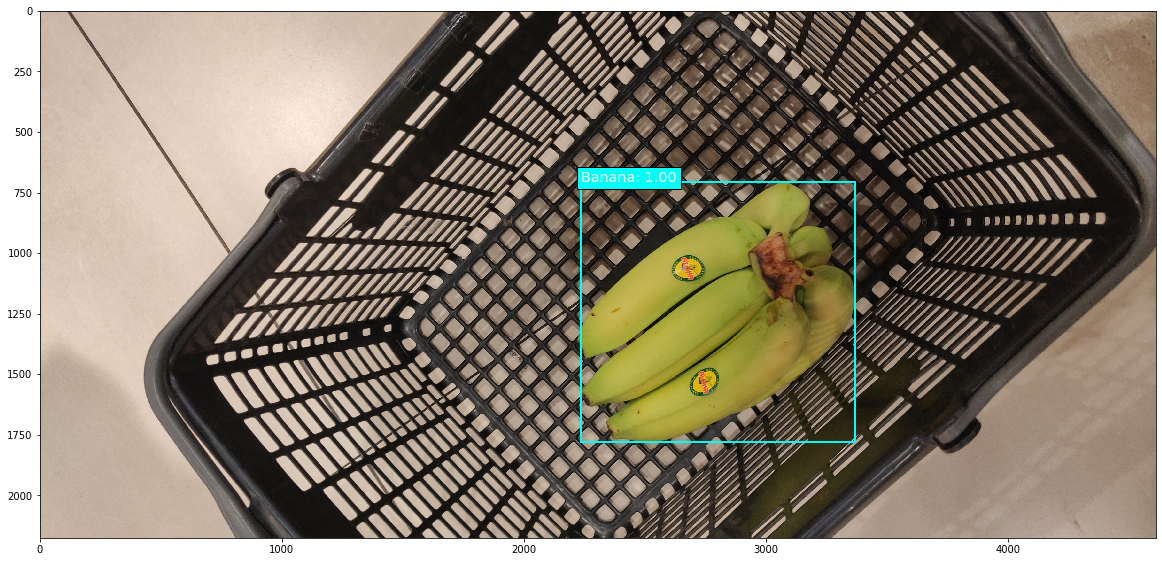

end


In [0]:

# %% Block 7a: Plotting Predictions
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes + 1)).tolist()
classes = ['background','Banana', 'Apple']

# Select the test image to display
select_idx = 0

img = cv2.imread(test_imgs[select_idx])
plt.figure(figsize=(20, 12))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

current_axis = plt.gca()

print('Current Selected Image shape:', img.shape)

for box in y_pred[select_idx][0]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    print('coordinates when plotting',xmin, ymin, xmax, ymax)
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, color=color, fill=False, linewidth=2))
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor': color, 'alpha': 1.0})

plt.show()
print('end')
